In [1]:
import time
import os
import torch
from torch import nn
import torch.nn.functional as F

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
#ONLY RUN THIS ONCE
os.chdir("..")
os.path.abspath(os.curdir)

'/Users/jackgibson/Documents/advanced_ml/how_the_bear_got_a_C'

#### Custom DataLoaders
Use classes and functions created in model_framework.py to frame out 4 different models using pytorch dataloaders...

In [3]:
import model_framework

In [4]:
FEATURES = [
    "stars",
    "review_count",
    "is_open",
    "n_reviews",
    "avg_rating",
    "IR_regular",
    "IR_follow_up",
    "IR_other",
    "Chester",
    "Bucks",
    "Philadelphia",
    "Delaware",
    "Montgomery",
    "Berks",
]

In [5]:
train = pd.read_csv("data/phila/split/train.csv")
#subset for only features that are floats or ints
# train = train.select_dtypes(include=[np.float64,np.int64])

In [73]:
train_dataset = model_framework.ReviewsDataset(vectorizer=model_framework.Vectorizer,
                              df_filepath="data/phila/split/train.csv",
                              features=FEATURES, max_features=7000)
val_dataset = model_framework.ReviewsDataset(vectorizer=model_framework.Vectorizer,
                              df_filepath="data/phila/split/val.csv",
                              features=FEATURES, max_features=7000)
test_dataset = model_framework.ReviewsDataset(vectorizer=model_framework.Vectorizer,
                              df_filepath="data/phila/split/test.csv",
                              features=FEATURES, max_features=7000)

#### Model Testing

In [74]:
# wrap with any params here: https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
BATCH_SIZE = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=True)

In [63]:
example = next(iter(train_dataloader))
example

{'text': tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0198, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0896, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0728, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0084, 0.0224, 0.0082,  ..., 0.0078, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]),
 'labels': tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]),
 'features': tensor([[  4.5000, 308.0000,   1.0000,   3.0000,   4.3333,   0.0000,   0.0000,
            0.0000,   1.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
         [  4.5000,  98.0000,   1.0000,   8.0000,   4.7500,   1.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   1.0000,   0.0000,   0.0000,   0.0000],
         [  4.5000,  56.0000,   1.0000,   3.0000,   4.0000,   0.0000,   0.0000,
            0.0000,   0.0000,   0.0000,   0.00

In [75]:
def get_accuracy(val_dataloader, model):
    model.eval()
    
    with torch.no_grad():
        n_correct = 0
        n_examples = 0
        for data in val_dataloader:
            # get predicted probabilities, and labels with highest probability
            predicted_labels = model(data['text'])
            # predicted_labels = predicted_labels > 0.5
            # correct = data['labels'] > 0.5

            #compute argmax
            _, preds = torch.max(predicted_labels, 1)
            # _, labels = torch.max(data['labels'], 1)

            batch_correct = (preds == data['labels']).sum().item()
            n_correct += batch_correct
            n_examples += len(data['labels'])
    
    # calculate average accuracy across all batches
    average_accuracy = n_correct / n_examples
    return average_accuracy

In [76]:
def train_model(model, train_dataloader, val_dataloader, optimizer, loss_function, epochs):
 # Sets the module in training mode.
    val_accuracies=[]

    for n_epoch in range(epochs):

        model.train()

        for data in train_dataloader:
            y_hat = model(data['text'])

            optimizer.zero_grad()
            loss = loss_function(y_hat, data['labels'])
            

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        val_accuracies.append(get_accuracy(val_dataloader, model))
        
        if n_epoch % 100 == 0:
            print(f'At epoch {n_epoch} the loss is {loss:.3f}.')
    return val_accuracies

In [77]:
def plot_accuracies(val_accuracies):  
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies)

#### SVM

In [78]:
class Binary_SVM(nn.Module):
    def __init__(self, n_features):
        super(Binary_SVM, self).__init__()
        self.linear = nn.Linear(n_features, 2)
        self.nonlinearity = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear(x)
        #NOTABLY NO NON-LINEAR LAYER?
        out = self.nonlinearity(out)
        out = out.squeeze()
        return out

In [79]:
max_features=7000
svm_model = Binary_SVM(max_features)
epochs=300
lr = 1e-05
optimizer = torch.optim.SGD(svm_model.parameters(), lr=lr)
loss_function = nn.MultiMarginLoss()

swm_val_accuracies = train_model(svm_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0 the loss is 0.500.
At epoch 100 the loss is 0.500.
At epoch 200 the loss is 0.498.


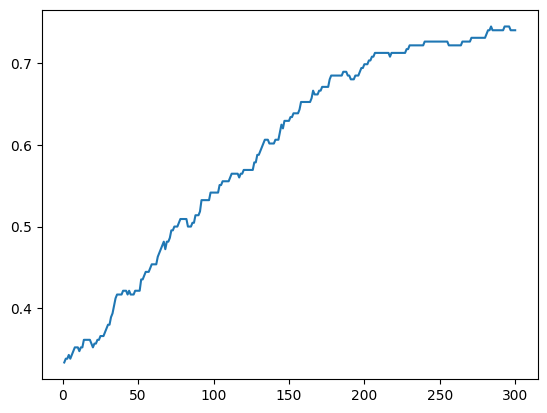

In [80]:
# why is this happening? lol
plot_accuracies(swm_val_accuracies)

### Logistic Regression

In [40]:
class LogisticRegression(torch.nn.Module):    
    def __init__(self, n_inputs, num_labels):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n_inputs, num_labels)

    def forward(self, x):
        
        return F.log_softmax(self.linear(x), dim=1)

In [81]:
# ADD THE RIGHT DIMENSIONS HERE?
n_inputs = 7000
n_outputs = 2

log_regr_model = LogisticRegression(n_inputs, n_outputs)
epochs = 300
lr = 1e-05
optimizer = torch.optim.SGD(log_regr_model.parameters(), lr=lr)
loss_function = nn.NLLLoss()

swm_val_accuracies = train_model(log_regr_model, train_dataloader, val_dataloader, optimizer, loss_function, epochs)

At epoch 0 the loss is 0.696.
At epoch 100 the loss is 0.685.
At epoch 200 the loss is 0.674.


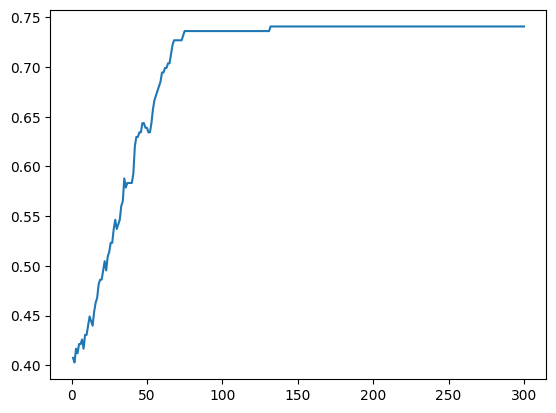

In [82]:
plot_accuracies(swm_val_accuracies)

### XGBoost